In [1]:
!pip uninstall fsspec -y
!pip install --upgrade fsspec
!pip install transformers accelerate datasets

Found existing installation: fsspec 2021.11.1
Uninstalling fsspec-2021.11.1:
  Successfully uninstalled fsspec-2021.11.1
     |████████████████████████████████| 133 kB 897 kB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
cudf 21.10.1 requires cupy-cuda110, which is not installed.
s3fs 2021.11.1 requires fsspec==2021.11.1, but you have fsspec 2022.1.0 which is incompatible.
gcsfs 2021.11.1 requires fsspec==2021.11.1, but you have fsspec 2022.1.0 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2021.12.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2021.12.0 which is incompatible.
     |████████████████████████████████| 58 kB 786 kB/s            


In [2]:
%env WANDB_DISABLED=true

env: WANDB_DISABLED=true


In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
import torch
from torch import nn

sns.set(rc = {'figure.figsize':(20,20)})
%matplotlib inline

In [4]:
data_dir = '/kaggle/input/commonlitreadabilityprize'
train_data_path = os.path.join(data_dir, 'train.csv')
test_data_path = os.path.join(data_dir, 'test.csv')

train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

print(len(train_df))
print(len(test_df))

2834
7


In [5]:
train_df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [6]:
huggingface_dir = '/kaggle/input/huggingface-bert'
model_dir = os.path.join(huggingface_dir, 'bert-base-cased')

tokenizer = BertTokenizer.from_pretrained(model_dir)
model = BertForSequenceClassification.from_pretrained(model_dir)

Some weights of the model checkpoint at /kaggle/input/huggingface-bert/bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [7]:
model


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [8]:
train_df.tail()

,id,url_legal,license,excerpt,target,standard_error
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128
2833,5b990ba77,https://en.wikibooks.org/wiki/Wikijunior:Biolo...,CC BY-SA 3.0,Animals are made of many cells. They eat thing...,0.300779,0.512379


In [9]:
test_df.head()

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [10]:
example = train_df.iloc[-1]
print(example)
print(example['excerpt'])

id                                                        5b990ba77
url_legal         https://en.wikibooks.org/wiki/Wikijunior:Biolo...
license                                                CC BY-SA 3.0
excerpt           Animals are made of many cells. They eat thing...
target                                                     0.300779
standard_error                                             0.512379
Name: 2833, dtype: object
Animals are made of many cells. They eat things and digest them inside. Most animals can move. Only animals have brains (though not even all animals do; jellyfish, for example, do not have brains).
Animals are found all over the earth. They dig in the ground, swim in the oceans, and fly in the sky.
Humans are a type of animal. So are dogs, cats, cows, horses, frogs, fish, and so on and on.
Animals can be divided into two main groups, vertebrates and invertebrates. Vertebrates can be further divided into mammals, fish, birds, reptiles, and amphibians. Invertebr

In [11]:
for i, excerpt in enumerate(train_df['excerpt'][:5]):
    print(f'Excerpt #{i}')
    print(excerpt + '\n')

Excerpt #0
When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.
This would have been an easy matter, but each traveller was obliged to wear snowsho

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='excerpt_len', ylabel='Density'>

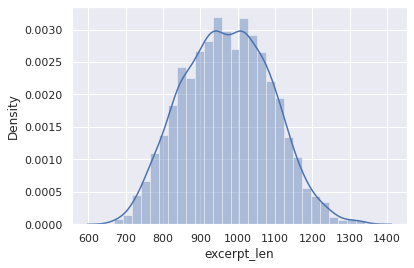

In [12]:
train_df['excerpt_len'] = train_df['excerpt'].apply(len)
sns.distplot(train_df['excerpt_len'], kde = True)

In [13]:
#unique characters
all_chars = set()
train_df['excerpt'].apply(lambda x: [all_chars.add(c) for c in x])
for c in sorted(all_chars):
    print(c + ' ', end='')
    
print('\n\n')
    
for c in sorted(all_chars):
    print(f'({c}, {str(ord(c))}) ', end='')


   ! " $ % & ' ( ) * + , - . / 0 1 2 3 4 5 6 7 8 9 : ; < = ? A B C D E F G H I J K L M N O P Q R S T U V W X Y Z [ ] _ a b c d e f g h i j k l m n o p q r s t u v w x y z ~ £ ­ ° ± ´ µ · ¼ ½ Æ × ß à á ä æ ç è é ê ë í î ñ õ ö ÷ ú ü œ – — ‘ ’ “ ” … 


(
, 10) ( , 32) (!, 33) (", 34) ($, 36) (%, 37) (&, 38) (', 39) ((, 40) (), 41) (*, 42) (+, 43) (,, 44) (-, 45) (., 46) (/, 47) (0, 48) (1, 49) (2, 50) (3, 51) (4, 52) (5, 53) (6, 54) (7, 55) (8, 56) (9, 57) (:, 58) (;, 59) (<, 60) (=, 61) (?, 63) (A, 65) (B, 66) (C, 67) (D, 68) (E, 69) (F, 70) (G, 71) (H, 72) (I, 73) (J, 74) (K, 75) (L, 76) (M, 77) (N, 78) (O, 79) (P, 80) (Q, 81) (R, 82) (S, 83) (T, 84) (U, 85) (V, 86) (W, 87) (X, 88) (Y, 89) (Z, 90) ([, 91) (], 93) (_, 95) (a, 97) (b, 98) (c, 99) (d, 100) (e, 101) (f, 102) (g, 103) (h, 104) (i, 105) (j, 106) (k, 107) (l, 108) (m, 109) (n, 110) (o, 111) (p, 112) (q, 113) (r, 114) (s, 115) (t, 116) (u, 117) (v, 118) (w, 119) (x, 120) (y, 121) (z, 122) (~, 126) (£, 163) (­, 173) (°, 176) (±

In [14]:
# Make a boolean column for excerpts with "hard characters"

hard_chars = set()
for c in all_chars:
    if ord(c) >= 176 and ord(c) <= 339:
        hard_chars.add(c)
        
print(hard_chars)

train_df['has_hard_char'] = train_df['excerpt'].apply(lambda x: any([c in hard_chars for c in x]))
sum(train_df['has_hard_char'])

{'ä', '÷', 'í', '´', 'ú', 'à', '×', '½', 'ü', 'õ', 'ß', 'î', 'ç', 'á', '¼', '·', 'ê', 'µ', '°', 'ë', 'ö', 'ñ', 'è', 'œ', 'æ', '±', 'é', 'Æ'}


128

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='excerpt', ylabel='Density'>

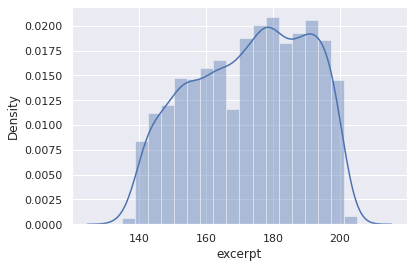

In [15]:
sns.distplot(train_df['excerpt'].apply(lambda x: len(x.split())), kde=True)

In [16]:
import warnings
warnings.filterwarnings("ignore")

<AxesSubplot:xlabel='target', ylabel='Density'>

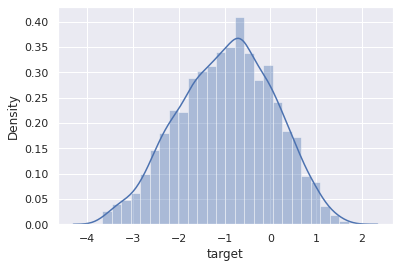

In [17]:
sns.distplot(train_df['target'], kde=True)

<AxesSubplot:xlabel='excerpt_len', ylabel='Density'>

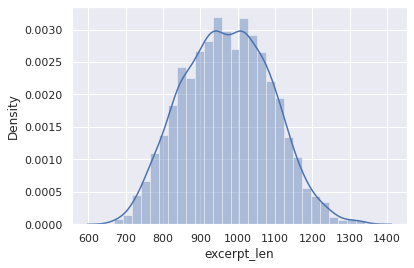

In [18]:
train_df['excerpt_len'] = train_df['excerpt'].apply(len)
sns.distplot(train_df['excerpt_len'], kde=True)

<AxesSubplot:xlabel='has_hard_char', ylabel='target'>

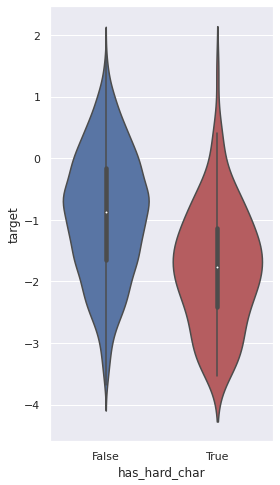

In [19]:
plt.subplots(figsize=(4, 8))

sns.violinplot(train_df['has_hard_char'], train_df['target'], palette=['b', 'r'])

<AxesSubplot:xlabel='excerpt_len', ylabel='target'>

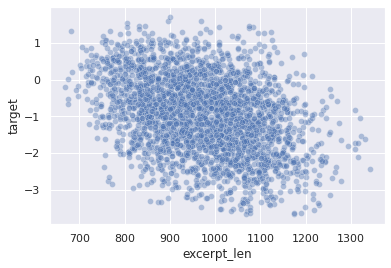

In [20]:
sns.scatterplot(train_df['excerpt_len'], train_df['target'], alpha=0.4)

<AxesSubplot:xlabel='excerpt_len', ylabel='target'>

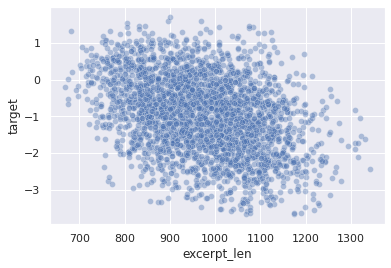

In [21]:
sns.scatterplot(train_df['excerpt_len'], train_df['target'], alpha=0.4)

In [22]:
correlation_matrix = np.corrcoef(train_df['excerpt_len'], train_df['target'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print('Linear fit r^2:', r_squared)

Linear fit r^2: 0.13161102336627012


<AxesSubplot:xlabel='standard_error', ylabel='Density'>

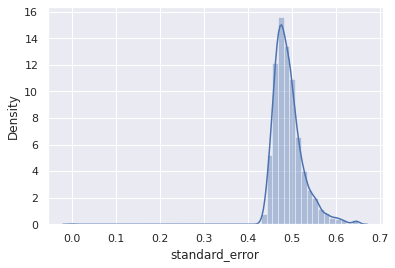

In [23]:
sns.distplot(train_df['standard_error'], kde=True)

<AxesSubplot:xlabel='target', ylabel='standard_error'>

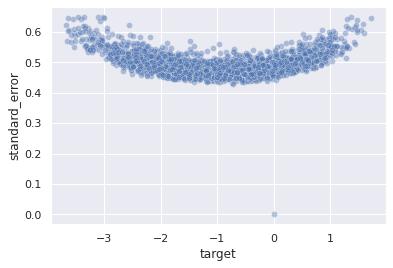

In [24]:
sns.scatterplot(train_df['target'], train_df['standard_error'], alpha=0.4)

In [25]:
train_df[train_df['target'] == 0]

,id,url_legal,license,excerpt,target,standard_error,excerpt_len,has_hard_char
106,436ce79fe,NaN,NaN,"The sun was shining in a cloudless sky, and no...",0.0,0.0,770,False


In [26]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [27]:
model.classifier = nn.Linear(768, 1)
model.num_labels = 1

In [28]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [29]:
#test
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([0]).unsqueeze(0)  # Batch size 1
inputs['labels'] = labels
outputs = model(**inputs)
loss = outputs.loss
logits = outputs.logits

print(outputs)
print(loss)
print(logits)

SequenceClassifierOutput(loss=tensor(0.0955, grad_fn=<MseLossBackward>), logits=tensor([[0.3090]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
tensor(0.0955, grad_fn=<MseLossBackward>)
tensor([[0.3090]], grad_fn=<AddmmBackward>)


In [30]:
train_datasets = load_dataset('csv', data_files=[train_data_path])
test_datasets = load_dataset('csv', data_files=[test_data_path])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-130b3ac4c8a0395f/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-54a5c9048a0d0f75/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
train_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error'],
        num_rows: 2834
    })
})

In [32]:
def tokenize_function(examples):
    return tokenizer(examples['excerpt'], padding='max_length', truncation=True, max_length=512)

In [33]:
f_train_datasets = train_datasets.map(tokenize_function, batched=True)
f_train_datasets = f_train_datasets.remove_columns(['id', 'url_legal', 'license', 'excerpt', 'standard_error'])
f_train_datasets = f_train_datasets.rename_column('target', 'labels')
f_train_datasets = f_train_datasets.shuffle(seed=42)

f_test_datasets = test_datasets.map(tokenize_function, batched=True)
f_test_datasets = f_test_datasets.remove_columns(['url_legal', 'license', 'excerpt'])

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [34]:
n_samples = len(f_train_datasets['train'])
n_train = int(0.9 * n_samples)

f_train_dataset = f_train_datasets['train'].select(range(n_train))
f_eval_dataset = f_train_datasets['train'].select(range(n_train, n_samples))

f_test_dataset = f_test_datasets['train']

In [35]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits, labels = logits.squeeze(), labels.squeeze()
    rmse = np.sqrt(np.mean((labels - logits) ** 2))
    return {'RMSE': rmse}

In [36]:
training_args = TrainingArguments(
    'training_args',
    num_train_epochs = 5,
    logging_steps = 200,
    learning_rate = 1e-4, #value taken from various trials and errors
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    evaluation_strategy = 'steps'
)

trainer = Trainer(
    model = model,
    train_dataset = f_train_dataset,
    eval_dataset = f_eval_dataset,
    compute_metrics = compute_metrics,
    args = training_args
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [37]:
trainer.train()

***** Running training *****
  Num examples = 2550
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1595


Step,Training Loss,Validation Loss,Rmse
200,0.827400,1.155277,1.074838
400,0.788200,0.988539,0.994253
600,0.964700,0.799087,0.893917
800,0.637300,0.547293,0.739792
1000,0.520200,0.588754,0.767303
1200,0.458500,0.549693,0.741412
1400,0.364700,0.469883,0.685480


***** Running Evaluation *****
  Num examples = 284
  Batch size = 8
***** Running Evaluation *****
  Num examples = 284
  Batch size = 8
Saving model checkpoint to training_args/checkpoint-500
Configuration saved in training_args/checkpoint-500/config.json
Model weights saved in training_args/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 284
  Batch size = 8
***** Running Evaluation *****
  Num examples = 284
  Batch size = 8
***** Running Evaluation *****
  Num examples = 284
  Batch size = 8
Saving model checkpoint to training_args/checkpoint-1000
Configuration saved in training_args/checkpoint-1000/config.json
Model weights saved in training_args/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 284
  Batch size = 8
***** Running Evaluation *****
  Num examples = 284
  Batch size = 8
Saving model checkpoint to training_args/checkpoint-1500
Configuration saved in training_args/checkpoint-1500/config.json
Model weight

TrainOutput(global_step=1595, training_loss=0.614132537363465, metrics={'train_runtime': 794.5995, 'train_samples_per_second': 16.046, 'train_steps_per_second': 2.007, 'total_flos': 3354635835648000.0, 'train_loss': 0.614132537363465, 'epoch': 5.0})

In [38]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 284
  Batch size = 8


{'eval_loss': 0.48164379596710205,
 'eval_RMSE': 0.6940056085586548,
 'eval_runtime': 5.6615,
 'eval_samples_per_second': 50.163,
 'eval_steps_per_second': 6.359,
 'epoch': 5.0}

In [39]:
model.save_pretrained('model_v1')

Configuration saved in model_v1/config.json
Model weights saved in model_v1/pytorch_model.bin


In [40]:
pred_output = trainer.predict(f_test_dataset)
pred_targets = pred_output.predictions.squeeze()
pred_ids = f_test_dataset['id']

submission = pd.DataFrame({
    'id': pred_ids,
    'target': pred_targets
})

submission.to_csv('submission.csv', index=False)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id.
***** Running Prediction *****
  Num examples = 7
  Batch size = 8
